***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df=pd.read_csv('Javascript.csv')

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'functions' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

Shape of our dataset: (43294, 406)


#### Let us analyze the balance of classes

In [12]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [13]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

dom_function_document.adoptNode(
dom_function_document.caretPositionFromPoint(
dom_function_document.caretRangeFromPoint(
dom_function_document.clear(
dom_function_document.createAttributeNS(
dom_function_document.createCDATASection(
dom_function_document.createEntityReference(
dom_function_document.createTouch(
dom_function_document.createTouchList(
dom_function_document.enableStyleSheetsForSet(
dom_function_document.exitPointerLock(
dom_function_document.getAnimations(
dom_function_document.getElementByName(
dom_function_document.getElementsByTagNameNS(
dom_function_document.normalizeDocument(
dom_function_document.queryCommandIndeterm(
dom_function_document.queryCommandValue(
dom_function_document.releaseCapture(
dom_function_document.releaseEvent(
dom_function_document.routeEvent(
dom_function_window.back(
dom_function_window.cancelIdleCallback(
dom_function_window.createImageBitmap(
dom_function_window.disableExternalCapture(
dom_function_window.dump(
dom_function_window.enableExt

In [14]:
### Check and converting data types
df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### Check for missing data

In [15]:
df.isnull().sum()

dom_function_document.captureEvents(                  0
dom_function_document.close(                          0
dom_function_document.createAttribute(                0
dom_function_document.createComment(                  0
dom_function_document.createDocumentFragment(         0
dom_function_document.createElement(                  0
dom_function_document.createElementNS(                0
dom_function_document.createEvent(                    0
dom_function_document.createNodeIterator(             0
dom_function_document.createProcessingInstruction(    0
dom_function_document.createRange(                    0
dom_function_document.createTextNode(                 0
dom_function_document.createTreeWalker(               0
dom_function_document.elementFromPoint(               0
dom_function_document.elementsFromPoint(              0
dom_function_document.execCommand(                    0
dom_function_document.getElementById(                 0
dom_function_document.getElementsByClassName(   

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [16]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

234 columns have more than 95% same values


In [17]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [18]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())
columns=columns.tolist()+['Target']

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [19]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_cookies,-0.349925,0.000000e+00,-152.836194,0.000000e+00
number_of_unsecure_cookies,-0.345278,0.000000e+00,-149.577298,0.000000e+00
number_of_non_http_only_cookies,-0.335473,0.000000e+00,-148.098816,0.000000e+00
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
number_of_http_only_cookies,-0.191954,0.000000e+00,-78.875103,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
number_of_secure_cookies,-0.111267,2.660489e-119,-48.907941,0.000000e+00



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [20]:
columns.remove('Target')

In [21]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [22]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [23]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.881507145951
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25944  3681    29625
True         423  4587     5010
__all__    26367  8268    34635

Accuracy of the KNN model for twst data is: 0.880586672826
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6474   909     7383
True         125  1151     1276
__all__     6599  2060     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855550743468
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29615    10    29625
True        4993    17     5010
__all__    34608    27    34635

Accuracy of the Logistic Regression model for twst data is: 0.852407899296
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7377     6     7383
True        1272     4     1276
__all__     8649    10     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.886502093258
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26023  3602    29625
True         329  4681     5010
__all__    26352  8283    34635

Accuracy of the Random Forest Classifier for twst data is: 0.880586672826
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6480   903     7383
True         131  1145     1276
__all__     6611  2048     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.869987007362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25763  3862    29625
True         641  4369     5010
__all__    26404  8231    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.869499942257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6439   944     7383
True         186  1090     1276
__all__     6625  2034     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.877551609643
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25974  3651    29625
True         590  4420     5010
__all__    26564  8071    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.876660122416
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6484   899     7383
True         169  1107     1276
__all__     6653  2006     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.887743611953
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26022  3603    29625
True         285  4725     5010
__all__    26307  8328    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.880471186049
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6474   909     7383
True         126  1150     1276
__all__     6600  2059     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.886704200953
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26024  3601    29625
True         323  4687     5010
__all__    26347  8288    34635

Accuracy of the Bagging model for twst data is: 0.879431805058
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6465   918     7383
True         126  1150     1276
__all__     6591  2068     8659



Neural Network-1
The accuracy of the model on training data is: 0.883268370146


Predicted  False  True  __all__
Actual                         
False      25976  3649    29625
True         394  4616     5010
__all__    26370  8265    34635

The accuracy of the model on test data is: 0.877353043077


Predicted  False  True  __all__
Actual                         
False       6466   917     7383
True         145  1131     1276
__all__     6611  2048     8659

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.881507,4587.0,25944.0,3681.0,423.0,0.124253,0.084431
LogisticRegression,0.855551,17.0,29615.0,10.0,4993.0,0.000338,0.996607
RandomForestClassifier,0.886502,4681.0,26023.0,3602.0,329.0,0.121586,0.065669
AdaBoostClassifier,0.869987,4369.0,25763.0,3862.0,641.0,0.130363,0.127944
GradientBoostingClassifier,0.877552,4420.0,25974.0,3651.0,590.0,0.123241,0.117764
ExtraTreeClassifier,0.887744,4725.0,26022.0,3603.0,285.0,0.121620,0.056886
BaggingClassifier,0.886704,4687.0,26024.0,3601.0,323.0,0.121553,0.064471
Neural Network-1,0.883268,4616.0,25976.0,3649.0,394.0,0.123173,0.078643


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.880587,1151.0,6474.0,909.0,125.0,0.123121,0.097962,0.889458
LogisticRegression,0.852408,4.0,7377.0,6.0,1272.0,0.000813,0.996865,0.501161
RandomForestClassifier,0.880587,1145.0,6480.0,903.0,131.0,0.122308,0.102665,0.887514
AdaBoostClassifier,0.869500,1090.0,6439.0,944.0,186.0,0.127861,0.145768,0.863185
GradientBoostingClassifier,0.876660,1107.0,6484.0,899.0,169.0,0.121766,0.132445,0.872894
ExtraTreeClassifier,0.880471,1150.0,6474.0,909.0,126.0,0.123121,0.098746,0.889067
BaggingClassifier,0.879432,1150.0,6465.0,918.0,126.0,0.124340,0.098746,0.888457
Neural Network-1,0.877353,1131.0,6466.0,917.0,145.0,0.124204,0.113636,0.888457


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [28]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [29]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43294, Columns: 59]
  Relationships:
    No relationships

In [30]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 6670 features
EntitySet scattered to workers in 10.770 seconds
Elapsed: 01:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [31]:
feature_matrix_sessions.head()

,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substr,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_Object.defineProperty(,js_function_Object.keys(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,js_function_unescape(,number_of_cookies,number_of_http_only_cookies,number_of_non_http_only_cookies,number_of_secure_cookies,number_of_unsecure_cookies,js_function_.add( + js_function_Math.random(,dom_function_document.querySelector( + js_function_.indexOf(,js_function_.defineProperty( + js_function_JSON.stringify(,dom_function_document.createElement( + js_function_.indexOf(,dom_function_document.getElementById( + js_function_.get(,js_function_.forEach( + number_of_cookies,js_function_.charAt( + number_of_cookies,js_function_Math.max( + number_of_unsecure_cookies,dom_function_window.open( + js_function_.join(,dom_function_window.open( + js_function_.keys(,js_function_.charAt( + js_function_Math.random(,js_function_encodeURIComponent( + js_function_isNaN(,dom_function_window.setTimeout( + number_of_unsecure_cookies,js_function_.add( + js_function_.call(,js_function_.indexOf( + js_function_.setTime(,dom_function_window.setTimeout( + js_function_.trim(,dom_function_window.open( + js_function_.add(,js_function_.concat( + js_function_.indexOf(,js_function_.call( + js_function_.get(,js_function_JSON.stringify( + number_of_unsecure_cookies,js_function_.add( + js_function_.keys(,js_function_.push( + js_function_.split(,js_function_.defineProperty( + js_function_.push(,js_function_.test( + js_function_.toString(,dom_function_document.getElementsByTagName( + js_function_parseInt(,js_function_.replace( + js_function_parseInt(,dom_function_document.getElementsByTagName( + js_function_.keys(,js_function_.indexOf( + js_function_.substr,js_function_isNaN( + js_function_JSON.parse(,js_function_.apply( + number_of_http_only_cookies,js_function_.get( + number_of_cookies,js_function_.log( + js_function_decodeURIComponent(,dom_function_window.open( + js_function_Math.round(,js_function_.call( + js_function_.substr,js_function_.add( + js_function_parseInt(,dom_function_document.write( + js_function_.push(,js_function_.setTime( + js_function_unescape(,js_function_Object.keys( + number_of_unsecure_cookies,js_function_.push( + js_function_Math.max(,js_function_.shift( + js_function_.test(,js_function_.slice( + js_function_Object.defineProperty(,js_function_JSON.parse( + js_function_parseInt(,js_function_.join( + js_function_Math.random(,dom_function_window.setTimeout( + js_function_.join(,js_function_.setTime( + js_function_.toLowerCase(,js_function_.defineProperty( + js_function_.pop(,js_function_.apply( + js_function_.push(,js_function_.setTime( + js_function_parseInt(,js_function_.indexOf( + js_function_Math.random(,dom_function_window.setTimeout( + js_function_.defineProperty(,js_function_.charAt( + js_function_encodeURIComponent(,js_function_.get( + js_function_.hasOwnProperty(,js_function_.call( + js_function

In [32]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [33]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [34]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [35]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [36]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [37]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [38]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [39]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43294, 55)

In [40]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['number_of_non_http_only_cookies / number_of_unsecure_cookies',
 'number_of_non_http_only_cookies / number_of_cookies',
 'js_function_.getTime( + number_of_unsecure_cookies',
 'dom_function_window.addEventListener( + number_of_cookies',
 'dom_function_document.getElementsByTagName( + number_of_unsecure_cookies',
 'dom_function_document.getElementsByTagName( + number_of_non_http_only_cookies',
 'dom_function_document.getElementsByTagName( + number_of_cookies',
 'number_of_unsecure_cookies / number_of_non_http_only_cookies',
 'number_of_secure_cookies / number_of_cookies',
 'number_of_secure_cookies + number_of_unsecure_cookies',
 'number_of_non_http_only_cookies + number_of_unsecure_cookies',
 'number_of_non_http_only_cookies + number_of_secure_cookies',
 'number_of_non_http_only_cookies',
 'number_of_cookies / number_of_unsecure_cookies',
 'number_of_cookies + number_of_secure_cookies',
 'number_of_cookies + number_of_non_http_only_cookies',
 'number_of_cookies + number_of_http_only_c

In [41]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [42]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.858928829219
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29565    61    29626
True        4825   184     5009
__all__    34390   245    34635

Accuracy of the KNN model for twst data is: 0.85367825384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7364    18     7382
True        1249    28     1277
__all__     8613    46     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.865078677638
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25677  3949    29626
True         724  4285     5009
__all__    26401  8234    34635

Accuracy of the Logistic Regression model for twst data is: 0.860953920776
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6368  1014     7382
True         190  1087     1277
__all__     6558  2101     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.871228526057
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25659  3967    29626
True         493  4516     5009
__all__    26152  8483    34635

Accuracy of the Random Forest Classifier for twst data is: 0.863494629865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6358  1024     7382
True         158  1119     1277
__all__     6516  2143     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.860401328136
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25395  4231    29626
True         604  4405     5009
__all__    25999  8636    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.857142857143
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6310  1072     7382
True         165  1112     1277
__all__     6475  2184     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.868889851306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25658  3968    29626
True         573  4436     5009
__all__    26231  8404    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.863494629865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6365  1017     7382
True         165  1112     1277
__all__     6530  2129     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.871574996391
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25661  3965    29626
True         483  4526     5009
__all__    26144  8491    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.863494629865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6359  1023     7382
True         159  1118     1277
__all__     6518  2141     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.871228526057
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25651  3975    29626
True         485  4524     5009
__all__    26136  8499    34635

Accuracy of the Bagging model for twst data is: 0.862686222428
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6351  1031     7382
True         158  1119     1277
__all__     6509  2150     8659



Neural Network-1
The accuracy of the model on training data is: 0.865858235897


Predicted  False  True  __all__
Actual                         
False      25536  4090    29626
True         556  4453     5009
__all__    26092  8543    34635

The accuracy of the model on test data is: 0.860607460446


Predicted  False  True  __all__
Actual                         
False       6336  1046     7382
True         161  1116     1277
__all__     6497  2162     8659

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [43]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [44]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.858929,184.0,29565.0,61.0,4825.0,0.002059,0.963266
LogisticRegression,0.865079,4285.0,25677.0,3949.0,724.0,0.133295,0.144540
RandomForestClassifier,0.871229,4516.0,25659.0,3967.0,493.0,0.133903,0.098423
AdaBoostClassifier,0.860401,4405.0,25395.0,4231.0,604.0,0.142814,0.120583
GradientBoostingClassifier,0.868890,4436.0,25658.0,3968.0,573.0,0.133936,0.114394
ExtraTreeClassifier,0.871575,4526.0,25661.0,3965.0,483.0,0.133835,0.096426
BaggingClassifier,0.871229,4524.0,25651.0,3975.0,485.0,0.134173,0.096826
Neural Network-1,0.865858,4453.0,25536.0,4090.0,556.0,0.138054,0.111000


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.853678,28.0,7364.0,18.0,1249.0,0.002438,0.978074,0.509744
LogisticRegression,0.860954,1087.0,6368.0,1014.0,190.0,0.137361,0.148786,0.856926
RandomForestClassifier,0.863495,1119.0,6358.0,1024.0,158.0,0.138716,0.123727,0.868778
AdaBoostClassifier,0.857143,1112.0,6310.0,1072.0,165.0,0.145218,0.129209,0.862786
GradientBoostingClassifier,0.863495,1112.0,6365.0,1017.0,165.0,0.137768,0.129209,0.866512
ExtraTreeClassifier,0.863495,1118.0,6359.0,1023.0,159.0,0.138580,0.124511,0.868455
BaggingClassifier,0.862686,1119.0,6351.0,1031.0,158.0,0.139664,0.123727,0.868304
Neural Network-1,0.860607,1116.0,6336.0,1046.0,161.0,0.141696,0.126077,0.868304


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [45]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [46]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

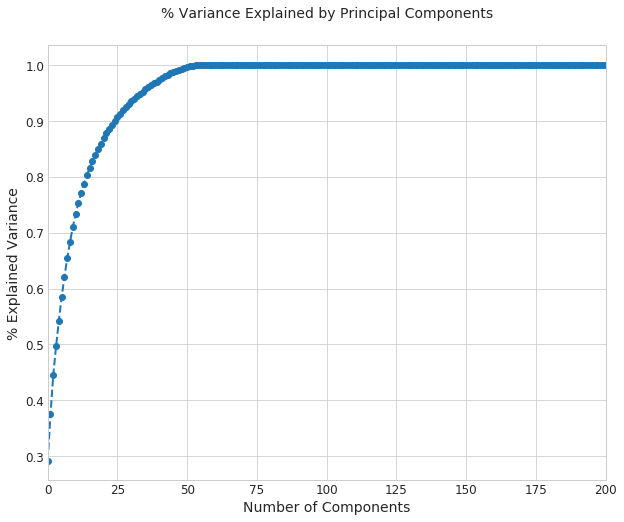

In [47]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [48]:
pca=PCA(n_components=50,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 50 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 50 components is: 0.995177087101


In [49]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [50]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [51]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,50).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.882026851451
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25994  3632    29626
True         454  4555     5009
__all__    26448  8187    34635

Accuracy of the KNN model for twst data is: 0.87689109597
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6445   937     7382
True         129  1148     1277
__all__     6574  2085     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855666233579
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29616    10    29626
True        4989    20     5009
__all__    34605    30    34635

Accuracy of the Logistic Regression model for twst data is: 0.851830465412
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7374     8     7382
True        1275     2     1277
__all__     8649    10     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.887743611953
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26037  3589    29626
True         299  4710     5009
__all__    26336  8299    34635

Accuracy of the Random Forest Classifier for twst data is: 0.878276937291
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6456   926     7382
True         128  1149     1277
__all__     6584  2075     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.878186805255
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26069  3557    29626
True         662  4347     5009
__all__    26731  7904    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.872733572006
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6472   910     7382
True         192  1085     1277
__all__     6664  1995     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.882748664646
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26069  3557    29626
True         504  4505     5009
__all__    26573  8062    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.87689109597
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6466   916     7382
True         150  1127     1277
__all__     6616  2043     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.888580915259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26050  3576    29626
True         283  4726     5009
__all__    26333  8302    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.87793047696
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6451   931     7382
True         126  1151     1277
__all__     6577  2082     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.887483759203
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26051  3575    29626
True         322  4687     5009
__all__    26373  8262    34635

Accuracy of the Bagging model for twst data is: 0.878161450514
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6460   922     7382
True         133  1144     1277
__all__     6593  2066     8659



Neural Network-1
The accuracy of the model on training data is: 0.886184495453


Predicted  False  True  __all__
Actual                         
False      26060  3566    29626
True         376  4633     5009
__all__    26436  8199    34635

The accuracy of the model on test data is: 0.876198175309


Predicted  False  True  __all__
Actual                         
False       6451   931     7382
True         141  1136     1277
__all__     6592  2067     8659

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [52]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [53]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.882027,4555.0,25994.0,3632.0,454.0,0.122595,0.090637
LogisticRegression,0.855666,20.0,29616.0,10.0,4989.0,0.000338,0.996007
RandomForestClassifier,0.887744,4710.0,26037.0,3589.0,299.0,0.121144,0.059693
AdaBoostClassifier,0.878187,4347.0,26069.0,3557.0,662.0,0.120063,0.132162
GradientBoostingClassifier,0.882749,4505.0,26069.0,3557.0,504.0,0.120063,0.100619
ExtraTreeClassifier,0.888581,4726.0,26050.0,3576.0,283.0,0.120705,0.056498
BaggingClassifier,0.887484,4687.0,26051.0,3575.0,322.0,0.120671,0.064284
Neural Network-1,0.886184,4633.0,26060.0,3566.0,376.0,0.120367,0.075065


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.876891,1148.0,6445.0,937.0,129.0,0.126930,0.101018,0.886026
LogisticRegression,0.851830,2.0,7374.0,8.0,1275.0,0.001084,0.998434,0.500241
RandomForestClassifier,0.878277,1149.0,6456.0,926.0,128.0,0.125440,0.100235,0.887162
AdaBoostClassifier,0.872734,1085.0,6472.0,910.0,192.0,0.123273,0.150352,0.863187
GradientBoostingClassifier,0.876891,1127.0,6466.0,916.0,150.0,0.124086,0.117463,0.879226
ExtraTreeClassifier,0.877930,1151.0,6451.0,931.0,126.0,0.126118,0.098669,0.887607
BaggingClassifier,0.878161,1144.0,6460.0,922.0,133.0,0.124898,0.104150,0.885476
Neural Network-1,0.876198,1136.0,6451.0,931.0,141.0,0.126118,0.110415,0.885476


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [54]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,50).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [55]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [56]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [57]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [58]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.910970464135
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25666   3959    29625
True        1316  28309    29625
__all__    26982  32268    59250

Accuracy of the KNN model for twst data is: 0.86973091581
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6364  1019     7383
True         109  1167     1276
__all__     6473  2186     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.856388185654
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23202   6423    29625
True        2086  27539    29625
__all__    25288  33962    59250

Accuracy of the Logistic Regression model for twst data is: 0.800207876198
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5757  1626     7383
True         104  1172     1276
__all__     5861  2798     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.923375527426
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25549   4076    29625
True         464  29161    29625
__all__    26013  33237    59250

Accuracy of the Random Forest Classifier for twst data is: 0.869961889364
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6338  1045     7383
True          81  1195     1276
__all__     6419  2240     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.877367088608
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25387   4238    29625
True        3028  26597    29625
__all__    28415  30835    59250

Accuracy of the Ada Boost Classifier for twst data is: 0.86153135466
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6335  1048     7383
True         151  1125     1276
__all__     6486  2173     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.895898734177
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25150   4475    29625
True        1693  27932    29625
__all__    26843  32407    59250

Accuracy of the Gradient Boosting Classifier for twst data is: 0.857142857143
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6259  1124     7383
True         113  1163     1276
__all__     6372  2287     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.923831223629
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25559   4066    29625
True         447  29178    29625
__all__    26006  33244    59250

Accuracy of the Extra Tree Classifier for twst data is: 0.869615429033
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6337  1046     7383
True          83  1193     1276
__all__     6420  2239     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.923156118143
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25551   4074    29625
True         479  29146    29625
__all__    26030  33220    59250

Accuracy of the Bagging model for twst data is: 0.868576048042
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6326  1057     7383
True          81  1195     1276
__all__     6407  2252     8659



Neural Network-1
The accuracy of the model on training data is: 0.914548523207


Predicted  False   True  __all__
Actual                          
False      25127   4498    29625
True         565  29060    29625
__all__    25692  33558    59250

The accuracy of the model on test data is: 0.857027370366


Predicted  False  True  __all__
Actual                         
False       6215  1168     7383
True          70  1206     1276
__all__     6285  2374     8659

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [59]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [60]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.910970,28309.0,25666.0,3959.0,1316.0,0.133637,0.044422
LogisticRegression,0.856388,27539.0,23202.0,6423.0,2086.0,0.216810,0.070414
RandomForestClassifier,0.923376,29161.0,25549.0,4076.0,464.0,0.137586,0.015662
AdaBoostClassifier,0.877367,26597.0,25387.0,4238.0,3028.0,0.143055,0.102211
GradientBoostingClassifier,0.895899,27932.0,25150.0,4475.0,1693.0,0.151055,0.057148
ExtraTreeClassifier,0.923831,29178.0,25559.0,4066.0,447.0,0.137249,0.015089
BaggingClassifier,0.923156,29146.0,25551.0,4074.0,479.0,0.137519,0.016169
Neural Network-1,0.914549,29060.0,25127.0,4498.0,565.0,0.151831,0.019072


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.869731,1167.0,6364.0,1019.0,109.0,0.138020,0.085423,0.888279
LogisticRegression,0.800208,1172.0,5757.0,1626.0,104.0,0.220236,0.081505,0.849130
RandomForestClassifier,0.869962,1195.0,6338.0,1045.0,81.0,0.141541,0.063480,0.897489
AdaBoostClassifier,0.861531,1125.0,6335.0,1048.0,151.0,0.141948,0.118339,0.869857
GradientBoostingClassifier,0.857143,1163.0,6259.0,1124.0,113.0,0.152242,0.088558,0.879600
ExtraTreeClassifier,0.869615,1193.0,6337.0,1046.0,83.0,0.141677,0.065047,0.896638
BaggingClassifier,0.868576,1195.0,6326.0,1057.0,81.0,0.143167,0.063480,0.896677
Neural Network-1,0.857027,1206.0,6215.0,1168.0,70.0,0.158201,0.054859,0.896677


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [62]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [63]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12572, 293)


,dom_function_document.captureEvents(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.execCommand(,dom_function_document.getElementById(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.dispatchEvent(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.getComputedStyle(,dom_function_window.getSelection(,dom_function_window.matchMedia(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollTo(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setTimeout(,dom_function_window.stop(,js_function_.add(,js_function_.all(,js_function_.anchor(,js_function_.apply(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_function_.call(,js_function_.catch(,js_function_.charAt(,js_function_.charCodeAt(,js_function_.clear(,js_function_.codePointAt(,js_function_.compile(,js_function_.concat(,js_function_.construct(,js_function_.defineProperty(,js_function_.delete(,js_function_.deleteProperty(,js_function_.endWith(,js_function_.entries(,js_function_.every(,js_function_.exec(,js_function_.fill(,js_function_.filter(,js_function_.find(,js_function_.findIndex(,js_function_.flatMap(,js_function_.fontcolor(,js_function_.forEach(,js_function_.from(,js_function_.get(,js_function_.getDate(,js_function_.getDay(,js_function_.getFullYear(,js_function_.getHours(,js_function_.getInt16(,js_function_.getInt32(,js_function_.getInt8(,js_function_.getMilliseconds(,js_function_.getMinutes(,js_function_.getMonth(,js_function_.getOwnPropertyDescriptor(,js_function_.getPrototypeOf(,js_function_.getSeconds(,js_function_.getTime(,js_function_.getTimezoneOffset(,js_function_.getUTCDate(,js_function_.getUTCDay(,js_function_.getUTCFullYear(,js_function_.getUTCHours(,js_function_.getUTCMilliseconds(,js_function_.getUTCMinutes(,js_function_.getUTCMonth(,js_function_.getUTCSeconds(,js_function_.getUint16(,js_function_.getUint32(,js_function_.getUint8(,js_function_.getYear(,js_function_.has(,js_function_.hasOwnProperty(,js_function_.includes(,js_function_.indexOf(,js_function_.isExtensible(,js_function_.isPrototypeOf(,js_function_.italics(,js_function_.join(,js_function_.keys(,js_function_.lastIndexOf(,js_function_.link(,js_function_.localeCompare(,js_function_.log(,js_function_.map(,js_function_.match(,js_function_.min(,js_function_.next(,js_function_.normalize(,js_function_.of(,js_function_.ownKeys(,js_function_.padEnd(,js_f

In [64]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [77]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [78]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [79]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.895793974346
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4249   801     5050
True         247  4760     5007
__all__     4496  5561    10057

Accuracy of the KNN model for twst data is: 0.888270377734
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1041   195     1236
True          86  1193     1279
__all__     1127  1388     2515



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.852838818733
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3926  1124     5050
True         356  4651     5007
__all__     4282  5775    10057

Accuracy of the Logistic Regression model for twst data is: 0.846918489066
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        962   274     1236
True         111  1168     1279
__all__     1073  1442     2515



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.916277219847
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4294   756     5050
True          86  4921     5007
__all__     4380  5677    10057

Accuracy of the Random Forest Classifier for twst data is: 0.898608349901
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1049   187     1236
True          68  1211     1279
__all__     1117  1398     2515



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.870836233469
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4316   734     5050
True         565  4442     5007
__all__     4881  5176    10057

Accuracy of the Ada Boost Classifier for twst data is: 0.862425447316
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1061   175     1236
True         171  1108     1279
__all__     1232  1283     2515



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.892413244506
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4267   783     5050
True         299  4708     5007
__all__     4566  5491    10057

Accuracy of the Gradient Boosting Classifier for twst data is: 0.885487077535
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1048   188     1236
True         100  1179     1279
__all__     1148  1367     2515



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.919160783534
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4309   741     5050
True          72  4935     5007
__all__     4381  5676    10057

Accuracy of the Extra Tree Classifier for twst data is: 0.899801192843
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1053   183     1236
True          69  1210     1279
__all__     1122  1393     2515



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.916177786616
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4294   756     5050
True          87  4920     5007
__all__     4381  5676    10057

Accuracy of the Bagging model for twst data is: 0.895427435388
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1040   196     1236
True          67  1212     1279
__all__     1107  1408     2515



Neural Network-1
The accuracy of the model on training data is: 0.902058267879


Predicted  False  True  __all__
Actual                         
False       4310   740     5050
True         245  4762     5007
__all__     4555  5502    10057

The accuracy of the model on test data is: 0.886679920477


Predicted  False  True  __all__
Actual                         
False       1052   184     1236
True         101  1178     1279
__all__     1153  1362     2515

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [80]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [81]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.895794,4760.0,4249.0,801.0,247.0,0.158614,0.049331
LogisticRegression,0.852839,4651.0,3926.0,1124.0,356.0,0.222574,0.071100
RandomForestClassifier,0.916277,4921.0,4294.0,756.0,86.0,0.149703,0.017176
AdaBoostClassifier,0.870836,4442.0,4316.0,734.0,565.0,0.145347,0.112842
GradientBoostingClassifier,0.892413,4708.0,4267.0,783.0,299.0,0.155050,0.059716
ExtraTreeClassifier,0.919161,4935.0,4309.0,741.0,72.0,0.146733,0.014380
BaggingClassifier,0.916178,4920.0,4294.0,756.0,87.0,0.149703,0.017376
Neural Network-1,0.902058,4762.0,4310.0,740.0,245.0,0.146535,0.048931


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888270,1193.0,1041.0,195.0,86.0,0.157767,0.067240,0.887496
LogisticRegression,0.846918,1168.0,962.0,274.0,111.0,0.221683,0.086787,0.845765
RandomForestClassifier,0.898608,1211.0,1049.0,187.0,68.0,0.151294,0.053167,0.897769
AdaBoostClassifier,0.862425,1108.0,1061.0,175.0,171.0,0.141586,0.133698,0.862358
GradientBoostingClassifier,0.885487,1179.0,1048.0,188.0,100.0,0.152104,0.078186,0.884855
ExtraTreeClassifier,0.899801,1210.0,1053.0,183.0,69.0,0.148058,0.053948,0.898997
BaggingClassifier,0.895427,1212.0,1040.0,196.0,67.0,0.158576,0.052385,0.894520
Neural Network-1,0.886680,1178.0,1052.0,184.0,101.0,0.148867,0.078968,0.894520


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [82]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [83]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')